In [1]:
%run mpl_config.py

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from modelling_functions import (
    LSTMModel,
    LinearModel,
    prepare_dataloaders,
    load_and_preprocess_data,
    evaluate_anomalies,
)


from eda_helper import (
    get_custom_palette,
    get_custom_heatmap,
    get_custom_colormap,
    extract_values_from_filename,
)

custom_palette = get_custom_palette()
custom_heatmap = get_custom_heatmap()
custom_colormap = get_custom_colormap()

print(os.getcwd())

c:\#code\#python\#current\mres-project\analysis_files


In [3]:
cwd = os.getcwd()
column_names = [
    "MAE",
    "MSE",
    "RMSE",
    "R^2",
    "Model",
    "Training Time (s)",
    "Test Number",
    "Completeness",
    "Sequence Length",
    "WindowSize",
    "Horizon",
]
performance = pd.read_csv(
    cwd + "\\performance_metrics_mm.csv", header=None, names=column_names
)
runtime = pd.read_csv(cwd + "\\runtime_metrics_mm.csv")
weights = pd.read_csv(cwd + "\\weights_mm.csv")

selected_columns = [
    "MAE",
    "MSE",
    "RMSE",
    "R^2",
    "Training Time (s)",
    "Test Number",
    "Completeness",
    "Sequence Length",
    "WindowSize",
    "Horizon",
]

performance_lstm = performance[performance["Model"] == "LSTM"][selected_columns]
performance_linear = performance[performance["Model"] == "Linear"][selected_columns]


def process_data(dataframe):
    """
    Process the given dataframe based on the provided steps.
    Args:
    - dataframe (pd.DataFrame): The dataframe to process.
    Returns:
    - pd.DataFrame: The processed dataframe.
    """
    dataframe = dataframe.sort_values(by="R^2").reset_index(drop=True)
    grouped_dataframe = dataframe.groupby(
        ["Completeness", "Horizon", "WindowSize"]
    ).mean()
    grouped_dataframe.reset_index(inplace=True)
    sorted_dataframe = grouped_dataframe.sort_values(
        by="Training Time (s)"
    ).reset_index(drop=True)

    return sorted_dataframe


# Process the dataframes
sorted_lstm_performance = process_data(performance_lstm)
sorted_linear_performance = process_data(performance_linear)

# Multiplying index value by length of window_sizes to get the correct index for viewing
sorted_linear_performance.index = sorted_lstm_performance.iloc[::6].index

window_values = np.sort(sorted_lstm_performance["WindowSize"].unique())
horizon_values = np.sort(sorted_lstm_performance["Horizon"].unique())
completeness_values = np.sort(sorted_lstm_performance["Completeness"].unique())

# Additional operations for linear_data
sorted_linear_performance = sorted_linear_performance.sort_values(
    ["Completeness", "Horizon"], ascending=[False, True]
).reset_index(drop=True)

In [4]:
def extract_values_from_filename(filename):
    """
    Extracts the Completeness, Sequence Length, Horizon, and Window Size values
    from the given filename using regular expressions.

    Args:
    - filename (str): The filename to extract the values from.

    Returns:
    - dict: A dictionary containing the extracted values. Returns None for values not found.
    """
    # Regular expressions for each value
    regex_patterns = {
        "Completeness": r"Completeness([\d.]+)",
        "SequenceLength": r"SequenceLength(\d+)",
        "Horizon": r"Horizon(\d+)",
        "WindowSize": r"WindowSize(\d+)",
        "TestNumber": r"TestNumber(\d+)",
    }

    extracted_values = {}
    for key, pattern in regex_patterns.items():
        match = re.search(pattern, filename)
        if match:
            # Convert to float if it has a decimal point, else convert to int
            value = (
                float(match.group(1)) if "." in match.group(1) else int(match.group(1))
            )
            extracted_values[key] = value
        else:
            extracted_values[key] = None

    return extracted_values

In [5]:
custom_palette

[(0.25098039215686274, 0.3764705882352941, 0.6862745098039216),
 (1.0, 0.32941176470588235, 0.08627450980392157),
 (0.9921568627450981, 0.7843137254901961, 0.1843137254901961),
 (0.0, 0.6980392156862745, 0.6627450980392157),
 (0.9058823529411765, 0.9019607843137255, 0.9019607843137255),
 (0.5764705882352941, 0.3137254901960784, 0.6196078431372549),
 (0.0, 0.6627450980392157, 0.8784313725490196),
 (0.8117647058823529, 0.0, 0.44313725490196076)]

Removing incomplete days...
Initial number of records: 39904
Number of records in days @ 50% completeness: 39072
Proportion of records removed: 2.09%


Maximum consecutive days: 89
Starting from day number 1 in 2023

Overview of  Dataloader Parameters for Testing
Sequence Length: 864 | Horizon: 1 | Window Size: 1 | Completeness: 0.5
Length of test_inputs: 1711
Test inputs dtype: torch.float64, Test targets dtype: torch.float64
Test inputs type: <class 'torch.Tensor'>, Test targets type: <class 'torch.Tensor'>
Test inputs shape: torch.Size([1711, 1, 11]), Test targets shape: torch.Size([1711])
Predictions shape: (6843,), Inputs shape: (6843, 1, 11), Targets shape: (6843,)


NameError: name 'total_anomalies' is not defined

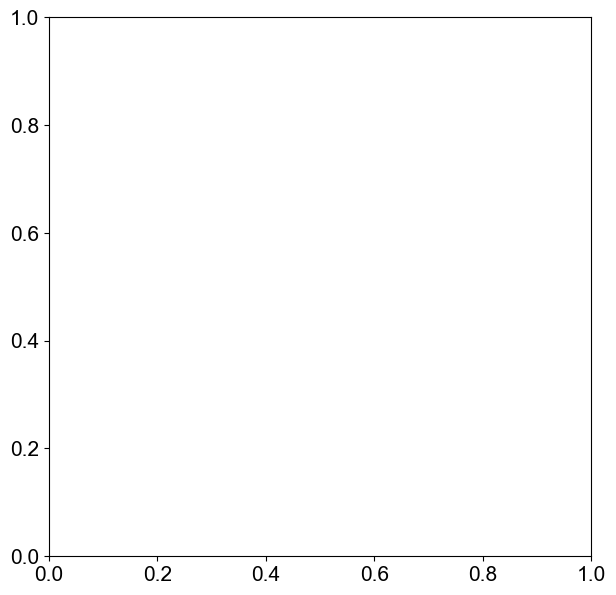

In [6]:
# Assuming custom_palette is predefined
custom_palette = get_custom_palette()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
model_folder_path = (
    r"C:\#code\#python\#current\mres-project\analysis_files\mv_model_states"
)
graph_save_path = (
    r"C:\#code\#python\#current\mres-project\analysis_files\mv_anomaly_graphs"
)
results_save_path = r"C:\#code\#python\#current\mres-project\analysis_files\mv_results"
os.makedirs(graph_save_path, exist_ok=True)
os.makedirs(results_save_path, exist_ok=True)

# Empty dataframe to store the results
results_list = []

input_feature_indices = list(range(0, 11))
target_feature_index = 0
stride = 1

completeness_value = 0.5
east_timeseries = load_and_preprocess_data(completeness_value)
data = east_timeseries

num_runs = 5  # Change to the desired number of runs

for model_file in os.listdir(model_folder_path):
    # Ensure it's a .pt file (PyTorch model state file)
    if not model_file.endswith(".pt"):
        continue

    # Create placeholders for metrics
    mean_errors_runs = []
    anomaly_percentages_runs = []
    anomaly_thresholds_runs = []
    rmse_runs = []

    for run in range(num_runs):
        # Extract values from filename
        values = extract_values_from_filename(model_file)
        sequence_length_value = values["SequenceLength"]
        horizon_value = values["Horizon"]
        window_size_value = values["WindowSize"]
        model_completeness_value = values["Completeness"]
        test_number = values["TestNumber"]
        # Load and preprocess data if completeness value changes

        print()
        print("Overview of  Dataloader Parameters for Testing")
        print(
            f"Sequence Length: {sequence_length_value} | Horizon: {horizon_value} | Window Size: {window_size_value} | Completeness: {completeness_value}"
        )

        (
            train_dataLoader,
            test_dataloader,
            test_inputs,
            test_targets,
            train_inputs,
            train_targets,
        ) = prepare_dataloaders(
            data=data,
            window_size=window_size_value,
            input_feature_indices=input_feature_indices,
            target_feature_index=target_feature_index,
            horizon=horizon_value,
            stride=stride,
            batch_size=1,
            shuffle=False,
        )

        print(f"Length of test_inputs: {len(test_inputs)}")

        # Load model state
        state_path = os.path.join(model_folder_path, model_file)
        if model_file.startswith("Linear"):
            model = LinearModel(input_size=len(input_feature_indices))
            model.load_state_dict(torch.load(state_path))
            model.to(device)
        else:
            model = LSTMModel(feature_dim=len(input_feature_indices))
            model.load_state_dict(torch.load(state_path))
            model.to(device)

        print(
            f"Test inputs dtype: {test_inputs.dtype}, Test targets dtype: {test_targets.dtype}"
        )
        print(
            f"Test inputs type: {type(test_inputs)}, Test targets type: {type(test_targets)}"
        )
        print(
            f"Test inputs shape: {test_inputs.shape}, Test targets shape: {test_targets.shape}"
        )
        with torch.inference_mode():
            train_inputs = train_inputs.float()
            predictions = model(train_inputs).squeeze().numpy()
            targets = train_targets.numpy()
            inputs = train_inputs.numpy()
        print(
            f"Predictions shape: {predictions.shape}, Inputs shape: {inputs.shape}, Targets shape: {targets.shape}"
        )

        errors = np.abs(predictions - targets)
        # Calculating the RMSE
        rmse = np.sqrt(np.mean(errors**2))
        totals = []
        percentages = []
        standard_deviations = list(np.arange(start=2, stop=10.01, step=0.1))

        for i in standard_deviations:
            threshold_i = errors.mean() + i * errors.std()
            anomalies_i = errors > threshold_i
            total_anomalies_i = np.sum(anomalies_i)
            anomaly_percentage_i = total_anomalies_i / len(targets)
            totals.append(total_anomalies_i)
            percentages.append(anomaly_percentage_i)

        # Set anomaly threshold
        error_deviations = 6
        percentages = [
            p * 100 for p in percentages
        ]  # Multiply by 100 to get percentage
        # Plotting the first graph
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title(
            f" Model number {test_number} \n Training metrics | Completeness threshold {model_completeness_value*100}% | Sequence length: {sequence_length_value} \n Evaluation metrics | Completenesss threshold: {completeness_value * 100}% | Error deviations: {error_deviations} \n Shared metrics | Horizon: {horizon_value} | Window size: {window_size_value} \n Results | Mean error: {errors.mean():.2f} | RMSE: {rmse:.2f} | Percentage anomalies: {(total_anomalies/sequence_length_value*100):.1f}% | Anomaly threshold: {anomaly_threshold}$\sigma$",
            fontsize=14,
        )
        ax.plot(standard_deviations, percentages, color=custom_palette[6], linewidth=1)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax.set_xlabel("Standard deviations from mean error ($\sigma$)")
        ax.set_ylabel("Anomaly percentage (%) - of total data points")
        ax.set_ylim(0, 7)
        # Round the y-axis tick labels to 2 decimal places
        ax.set_yticks(ax.get_yticks())

        fig.savefig(
            os.path.join(graph_save_path, f"{model_file.split('.p')[0]}_graph1.png")
        )
        plt.close(fig)

        # Plotting the second graph
        errors = np.abs(predictions - targets)

        anomaly_threshold = np.round(errors.mean() + error_deviations * errors.std(), 1)
        anomalies = errors > anomaly_threshold

        # Count total anomalies
        total_anomalies = np.sum(anomalies)

        anomaly_percentage = (total_anomalies / len(targets)) * 100

        # Create time vector
        time = np.arange(len(train_inputs))

        # Find the indices of all anomalies
        anomaly_indices = np.where(anomalies)[0]

        # Define t1 and t2
        t1, t2 = 300, 600

        # Filter those indices to only consider the [t1:t2] range
        filtered_anomaly_indices = anomaly_indices[
            (anomaly_indices >= t1) & (anomaly_indices < t2)
        ]

        # Use these filtered indices to get the anomaly_times and anomaly_values
        anomaly_times = time[filtered_anomaly_indices]
        anomaly_values = targets[filtered_anomaly_indices]

        print()
        print(
            f"Model number: {test_number} \n TRAINING METRICS | Completeness threshold {model_completeness_value*100}% | Sequence length: {sequence_length_value} | Model number {test_number} \n EVALUATION METRICS | Completenesss threshold: {completeness_value * 100}% | SHARED METRICS | Horizon: {horizon_value} | Window size: {window_size_value} \n Anomalies: {anomalies.shape} | Time: {time.shape} | Errors: {errors.shape} | Threshold: {threshold_i.shape} |Targets: {targets.shape} | Predictions: {predictions.shape}",
        )

        fig, ax = plt.subplots(figsize=(10, 9))
        # Plot the time series
        ax.plot(
            time[t1:t2],
            targets[t1:t2],
            label="Targets",
            linewidth=1,
            color=custom_palette[0],
        )
        ax.plot(
            time[t1:t2],
            predictions[t1:t2],
            linewidth=1,
            label="Predicted data",
            color=custom_palette[1],
        )

        # Mark the anomalies
        ax.scatter(
            anomaly_times,
            anomaly_values,
            label="Anomalies",
            color=custom_palette[7],
            marker="x",
            s=60,
            zorder=3,
        )
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax.set_ylim(-1, 3)
        ax.set_ylabel("Scaled value")
        ax.set_xlabel("Timestep")
        ax.set_title(
            f" Model number {test_number} \n Training metrics | Completeness threshold {model_completeness_value*100}% | Sequence length: {sequence_length_value} \n Evaluation metrics | Completenesss threshold: {completeness_value * 100}% | Error deviations: {error_deviations} \n Shared metrics | Horizon: {horizon_value} | Window size: {window_size_value} \n Results | Mean error: {errors.mean():.2f} | Percentage anomalies: {(total_anomalies/sequence_length_value*100):.1f}% | Anomaly threshold: {anomaly_threshold}$\sigma$",
            fontsize=14,
        )
        ax.legend(loc="upper right")
        fig.savefig(
            os.path.join(graph_save_path, f"{model_file.split('.p')[0]}_graph2.png")
        )
        plt.close(fig)

        # After computing necessary metrics:
        mean_errors_runs.append(errors.mean())
        rmse_runs.append(rmse)
        anomaly_percentages_runs.append(anomaly_percentage)
        anomaly_thresholds_runs.append(anomaly_threshold)

    # After all runs for a model, compute average metrics
    avg_mae = np.mean(mean_errors_runs)
    avg_rmse = np.mean(rmse_runs)
    avg_anomaly_percentage = np.mean(anomaly_percentages_runs)
    avg_anomaly_threshold = np.mean(anomaly_thresholds_runs)

    # Store the average evaluation results in the results_list
    results_list.append(
        {
            "Model": model_file,
            "MAE": avg_mae,
            "RMSE": avg_rmse,
            "Anomaly Percentage": avg_anomaly_percentage,
            "Anomaly Threshold": avg_anomaly_threshold,
        }
    )

# After the loop, create the dataframe
results_df = pd.DataFrame(results_list)

results_df.to_csv(
    os.path.join(
        results_save_path,
        f"features{len(input_feature_indices)}_completeness{completeness_value}_ed{error_deviations}_runs{num_runs}_evaluation_results.csv",
    ),
    index=False,
    mode="w",
)